<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Read the dataset
import pandas as pd
import numpy as np

df = pd.read_csv("improved_flood_dataset.csv")

print(df.shape)
print(df.columns)
print(df['Flood_Reported'].value_counts())


(10000, 19)
Index(['Region', 'Latitude', 'Longitude', 'Date', 'Rainfall_mm',
       'Tide_Level_m', 'Soil_Saturation_%', 'River_Level_m',
       'Land_Elevation_m', 'Distance_to_Coast_km', 'Cyclone_Alert',
       'Temperature_C', 'Humidity_%', 'Wind_Speed_kmph', 'Evaporation_mm',
       'Satellite_Cloud_Index', 'Infrastructure_Grade', 'Flood_Risk_Score',
       'Flood_Reported'],
      dtype='object')
Flood_Reported
0    7136
1    2864
Name: count, dtype: int64


In [3]:
#Dropping the target column
# Date processing
from sklearn.metrics import confusion_matrix

grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Target
y = df['Flood_Reported']

# Features
drop_cols = [
    'Flood_Reported',
    'Flood_Risk_Score',
    'Region',
    'Date'
]

X = df.drop(columns=drop_cols)



In [4]:
#Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [5]:
#Handling missing value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)


In [6]:
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)


In [ ]:
#Model implementation
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_imp, y_train)
#Evaluation report of random forest
from sklearn.metrics import classification_report

y_pred_rf = rf_model.predict(X_test_imp)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1427
           1       0.93      0.92      0.92       573

    accuracy                           0.96      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
import shap

explainer = shap.Explainer(rf_model, X)
shap_values = explainer(X)



100%|===================| 19992/20000 [13:36<00:00]       

In [ ]:
print("X shape:", X.shape)
print("Model expects:", rf_model.n_features_in_)
print("SHAP values shape:", np.array(shap_values[1]).shape)


X shape: (10000, 16)
Model expects: 16
SHAP values shape: (16, 2)


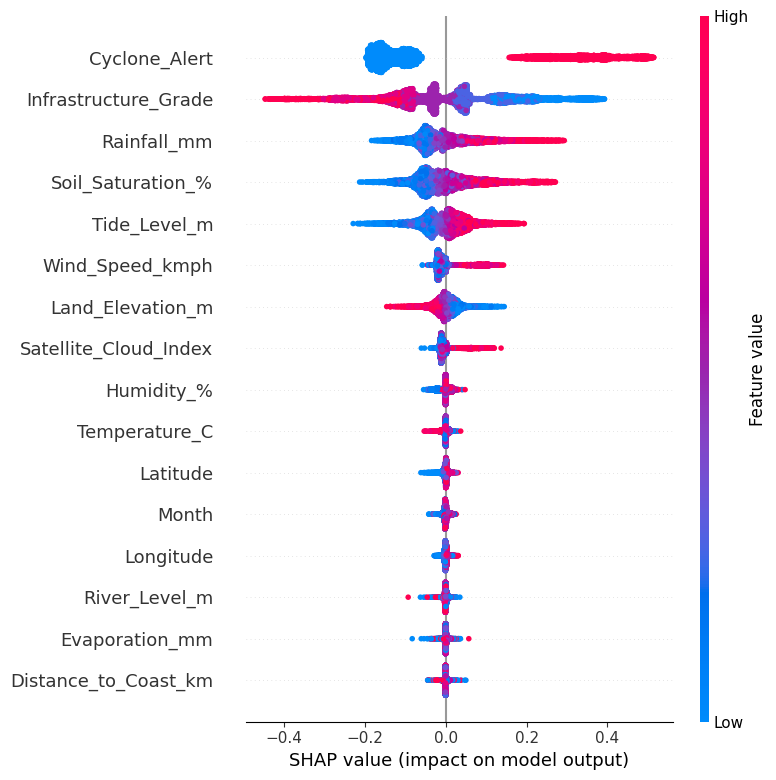

In [ ]:
shap.summary_plot(
    shap_values.values[:, :, 1],  # class = Flood (1)
    X,
    plot_type="dot",
    max_display=20
)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


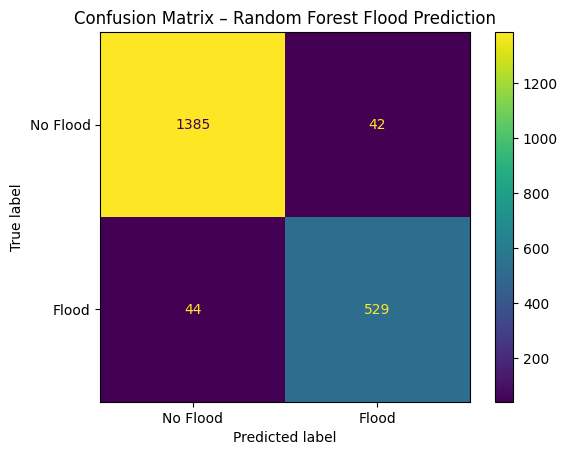

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot()
plt.title("Confusion Matrix – Random Forest Flood Prediction")
plt.show()


In [ ]:
#XGBOOST
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_imp, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import classification_report

y_pred_xgb = xgb_model.predict(X_test_imp)
print(classification_report(y_test, y_pred_xgb,digits=4))

              precision    recall  f1-score   support

           0     0.9860    0.9874    0.9867      1427
           1     0.9685    0.9651    0.9668       573

    accuracy                         0.9810      2000
   macro avg     0.9772    0.9762    0.9767      2000
weighted avg     0.9810    0.9810    0.9810      2000



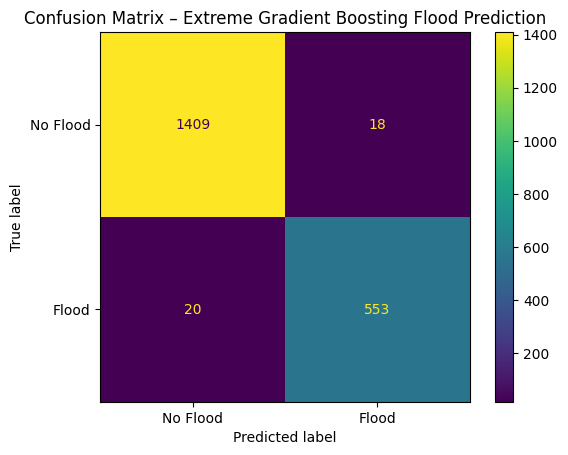

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = xgb_model.predict(X_test_imp)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot()
plt.title("Confusion Matrix – Extreme Gradient Boosting Flood Prediction")
plt.show()


100%|===================| 9975/10000 [03:05<00:00]       

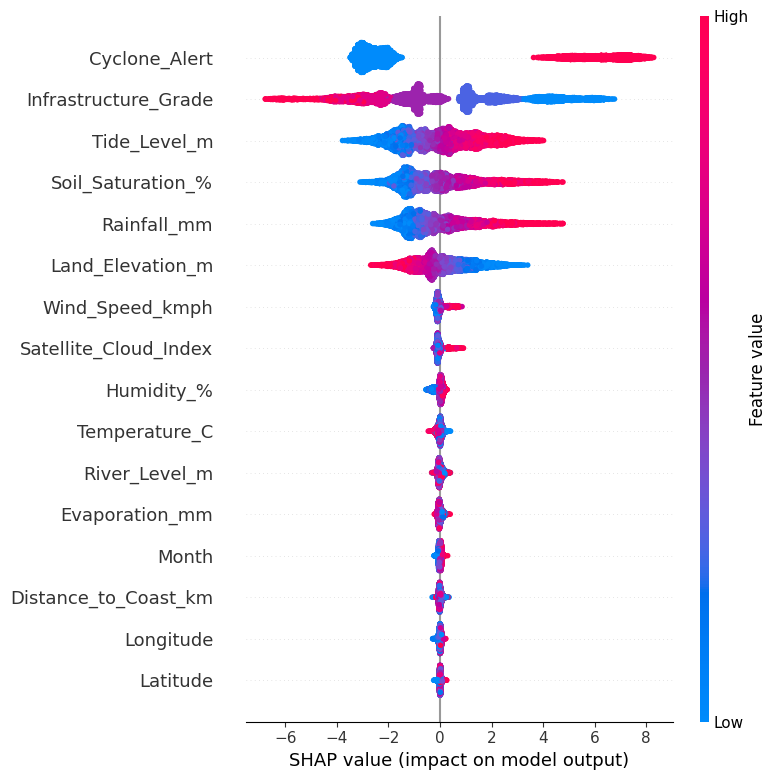

In [ ]:
import shap

explainer_xgb = shap.Explainer(xgb_model, X)
shap_values_xgb = explainer_xgb(X)



shap.summary_plot(
    shap_values_xgb.values,  # class = Flood (1)
    X,
    plot_type="dot",
    max_display=20
)


In [6]:
#SVM
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)


SVC(class_weight='balanced', probability=True, random_state=42)

In [7]:
from sklearn.metrics import classification_report

y_pred_svm = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9949    0.9629    0.9786      1427
           1     0.9144    0.9878    0.9497       573

    accuracy                         0.9700      2000
   macro avg     0.9547    0.9753    0.9641      2000
weighted avg     0.9719    0.9700    0.9703      2000



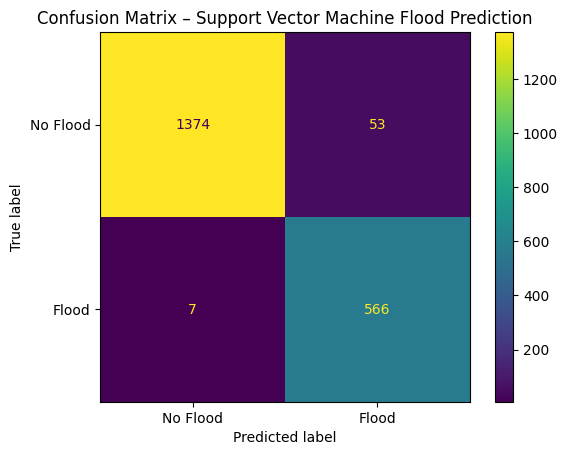

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = svm_model.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot()
plt.title("Confusion Matrix – Support Vector Machine Flood Prediction")
plt.show()

In [9]:
import shap
import numpy as np

X_np = X.values  # KernelExplainer needs numpy

X_bg = shap.sample(X_np, 100, random_state=42)

explainer_svm = shap.KernelExplainer(
    svm_model.predict_proba,   # CRITICAL
    X_bg
)



In [10]:
import shap
import numpy as np

# Use the SAME scaled data
X_train_s = X_train_scaled
X_test_s  = X_test_scaled



In [11]:
# 50 background samples is enough
X_bg = shap.sample(X_train_s, 50, random_state=42)


In [12]:
explainer_svm = shap.KernelExplainer(
    svm_model.predict_proba,   # MUST use predict_proba
    X_bg
)


In [13]:
# Explain only 100–200 points (never full dataset)
X_shap = shap.sample(X_test_s, 200, random_state=42)

shap_values_svm = explainer_svm.shap_values(X_shap)


  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
print("X_shap type:", type(X_shap))
print("X_shap shape:", X_shap.shape)



X_shap type: <class 'numpy.ndarray'>
X_shap shape: (200, 16)


In [22]:
def svm_flood_proba(X):
    return svm_model.predict_proba(X)[:, 1]   # ONLY class 1


In [23]:
import shap

X_bg = shap.sample(X_train_scaled, 50, random_state=42)

explainer_svm = shap.KernelExplainer(
    svm_flood_proba,   # 🔑 scalar output
    X_bg
)


In [24]:
X_shap = shap.sample(X_test_scaled, 200, random_state=42)

shap_values_svm = explainer_svm.shap_values(X_shap)

print(np.array(shap_values_svm).shape)


  0%|          | 0/200 [00:00<?, ?it/s]

(200, 16)


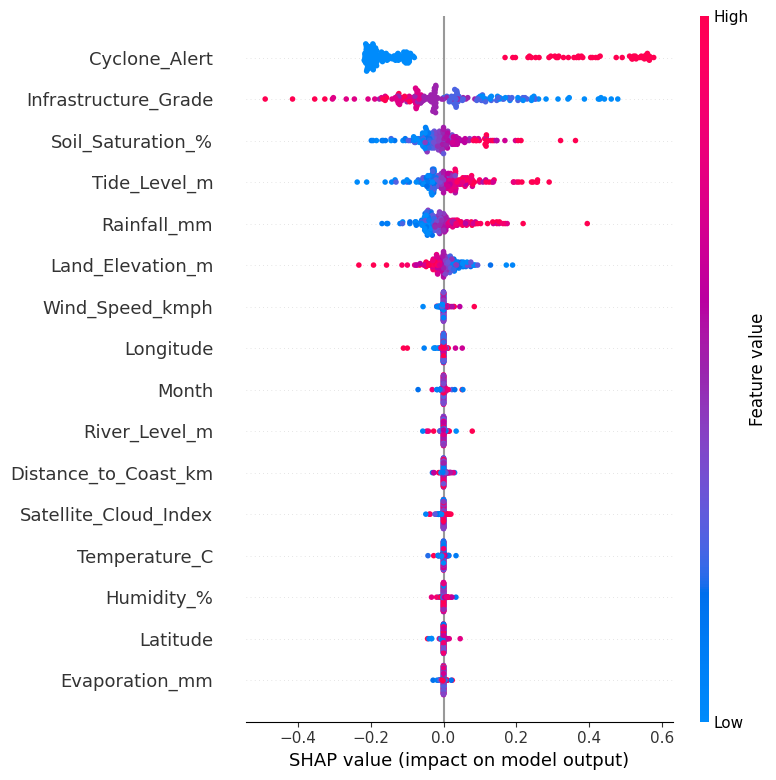

In [26]:
# DO NOT index with [1]
shap.summary_plot(
    shap_values_svm,     # ✅ full matrix
    X_shap,
    feature_names=X.columns,
    plot_type="dot",
    max_display=20
)



In [61]:
#FNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [62]:
fnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
optimizer = Adam(learning_rate=0.0002)


In [64]:
fnn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [65]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)




In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

history = fnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)



Epoch 1/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5620 - loss: 0.7083 - val_accuracy: 0.8050 - val_loss: 0.4710 - learning_rate: 2.0000e-04
Epoch 2/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7720 - loss: 0.4918 - val_accuracy: 0.8506 - val_loss: 0.3779 - learning_rate: 2.0000e-04
Epoch 3/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8058 - loss: 0.4323 - val_accuracy: 0.8831 - val_loss: 0.3072 - learning_rate: 2.0000e-04
Epoch 4/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8338 - loss: 0.3744 - val_accuracy: 0.9100 - val_loss: 0.2517 - learning_rate: 2.0000e-04
Epoch 5/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8588 - loss: 0.3368 - val_accuracy: 0.9319 - val_loss: 0.2094 - learning_rate: 2.0000e-04
Epoch 6/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8835 - loss: 0.2819 - val_accuracy: 0.9425 - val_loss: 0.1744 - learning_rate: 2.0000e-04
Epoch 7/150
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

In [67]:
# Predict probabilities on test data
y_prob_fnn = fnn_model.predict(X_test_scaled)

# Convert probabilities to class labels
y_pred_fnn = (y_prob_fnn > 0.5).astype(int).ravel()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [68]:
print("Classification Report – FNN\n")
print(classification_report(y_test, y_pred_fnn, digits=4))


Classification Report – FNN

              precision    recall  f1-score   support

           0     0.9937    0.9972    0.9955      1427
           1     0.9930    0.9843    0.9886       573

    accuracy                         0.9935      2000
   macro avg     0.9933    0.9907    0.9920      2000
weighted avg     0.9935    0.9935    0.9935      2000



Confusion Matrix:
 [[1423    4]
 [   9  564]]


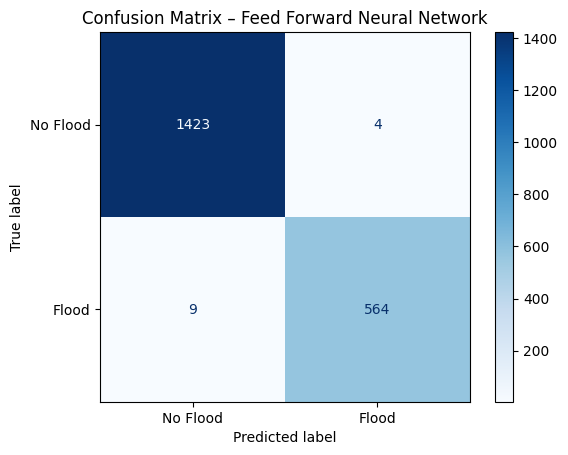

In [69]:
cm = confusion_matrix(y_test, y_pred_fnn)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Feed Forward Neural Network")
plt.show()


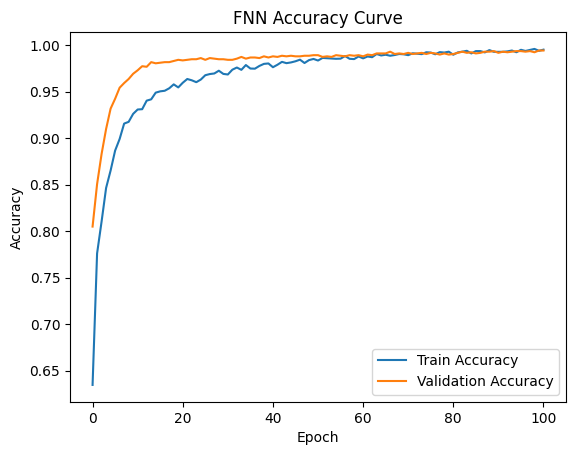

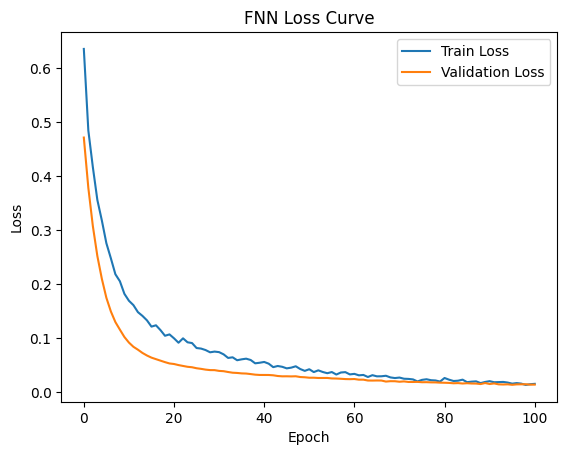

In [70]:
# Accuracy curve
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FNN Accuracy Curve')
plt.legend()
plt.show()

# Loss curve
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FNN Loss Curve')
plt.legend()
plt.show()
